In [ ]:
!pip install keras_applications

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.7 MB/s eta 0:00:00


In [ ]:

import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import random
from six.moves import urllib
import io
import shutil

from IPython.display import clear_output, Image, display, HTML


import tensorflow as tf
import tensorflow_hub as hub

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as sk_metrics
import time
from keras_applications.resnet import ResNet50
from keras_applications.resnet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

from keras.applications.inception_v3 import InceptionV3
from keras_applications.resnet50 import preprocess_input, decode_predictions, ResNet50
import keras.utils as image
from keras import regularizers
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Flatten
from keras import backend as K

In [ ]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
## set train, validation, and test paths


Mounted at /content/gdrive


In [ ]:
train_path = '/content/gdrive/MyDrive/dataset/train'
validation_path = '/content/gdrive/MyDrive/dataset/val'
test_path = '/content/gdrive/MyDrive/dataset/test'

In [ ]:
train_batches  = ImageDataGenerator().flow_from_directory(
    train_path, target_size=(224,224), classes = ['Fruit', 'Packages', 'Vegetables'], batch_size = 50)

validation_batches  = ImageDataGenerator().flow_from_directory(
    validation_path, target_size=(224,224), classes = ['Fruit', 'Packages', 'Vegetables'], batch_size = 10)

test_batches  = ImageDataGenerator().flow_from_directory(
    test_path, target_size=(224,224), classes = ['Fruit', 'Packages', 'Vegetables'], batch_size = 10)

Found 2640 images belonging to 3 classes.
Found 296 images belonging to 3 classes.
Found 2485 images belonging to 3 classes.


In [ ]:
for data_batch, labels_batch in train_batches:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break


data batch shape: (50, 224, 224, 3)
labels batch shape: (50, 3)


In [ ]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [ ]:
train_filenames = train_batches.filenames
steps_train = len(train_filenames)/train_batches.batch_size

## set steps per epoch for validation
validation_filenames = validation_batches.filenames
steps_valid = len(validation_filenames)/validation_batches.batch_size

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])
fit_generator1 = model.fit_generator(
      train_batches,
      steps_per_epoch=steps_train,
      epochs=10,
      validation_data=validation_batches,
      validation_steps=steps_valid)

<ipython-input-10-1bbdbd3071f9>:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  fit_generator1 = model.fit_generator(


Epoch 1/10
52/52 [==============================] - 1081s 21s/step - loss: 1.7173 - acc: 0.6352 - val_loss: 0.8896 - val_acc: 0.6182
Epoch 2/10
52/52 [==============================] - 377s 7s/step - loss: 0.5271 - acc: 0.8004 - val_loss: 0.9808 - val_acc: 0.6284
Epoch 3/10
52/52 [==============================] - 380s 7s/step - loss: 0.3281 - acc: 0.8761 - val_loss: 2.0784 - val_acc: 0.5101
Epoch 4/10
52/52 [==============================] - 388s 7s/step - loss: 0.2476 - acc: 0.9235 - val_loss: 1.2531 - val_acc: 0.6182
Epoch 5/10
52/52 [==============================] - 378s 7s/step - loss: 0.1420 - acc: 0.9553 - val_loss: 1.4115 - val_acc: 0.5845
Epoch 6/10
52/52 [==============================] - 379s 7s/step - loss: 0.1460 - acc: 0.9629 - val_loss: 2.2354 - val_acc: 0.6014
Epoch 7/10
52/52 [==============================] - 368s 7s/step - loss: 0.1590 - acc: 0.9587 - val_loss: 1.3971 - val_acc: 0.6554
Epoch 8/10
22/52 [===========>..................] - ETA: 3:26 - loss: 0.0048 - ac

<ipython-input-12-ac82883176fa>:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_acc, 'b', label='Validation acc', color = 'r')
<ipython-input-12-ac82883176fa>:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'b', label='Validation loss', color = 'r')


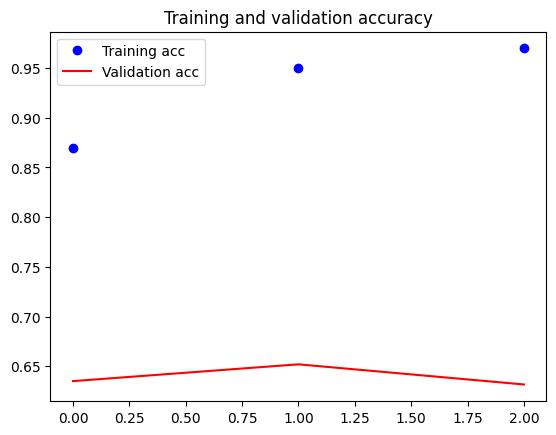

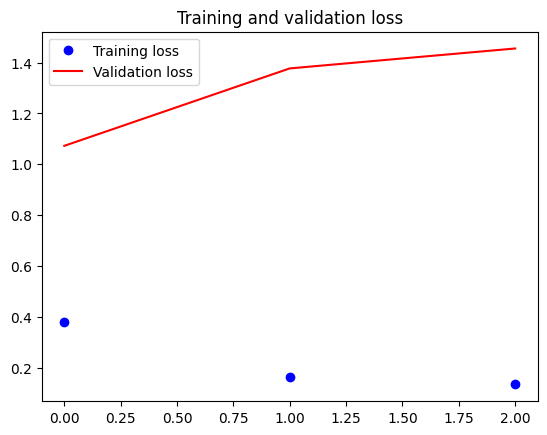

In [ ]:
import matplotlib.pyplot as plt

acc = fit_generator1.history['acc']
val_acc = fit_generator1.history['val_acc']
loss = fit_generator1.history['loss']
val_loss = fit_generator1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc', color = 'r')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color = 'r')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(224, 224),
        batch_size=50,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_path,
        target_size=(224, 224),
        batch_size=10,
        class_mode='categorical')

## set steps per epoch for train
train_filenames = train_generator.filenames
steps_train = len(train_filenames)/train_generator.batch_size

## set steps per epoch for validation
validation_filenames = validation_generator.filenames
steps_valid = len(validation_filenames)/validation_generator.batch_size

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

fit_generator_3 = model.fit_generator(
        train_generator,
        steps_per_epoch=steps_train,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=steps_valid)

Found 2640 images belonging to 3 classes.
Found 296 images belonging to 3 classes.


<ipython-input-13-0b004db99f15>:33: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  fit_generator_3 = model.fit_generator(


Epoch 1/50
52/52 [==============================] - 43s 787ms/step - loss: 0.7462 - acc: 0.6746 - val_loss: 0.9097 - val_acc: 0.6047
Epoch 2/50
52/52 [==============================] - 40s 764ms/step - loss: 0.6118 - acc: 0.7356 - val_loss: 1.1653 - val_acc: 0.5676
Epoch 3/50
52/52 [==============================] - 40s 764ms/step - loss: 0.5687 - acc: 0.7557 - val_loss: 0.8245 - val_acc: 0.6622
Epoch 4/50
52/52 [==============================] - 39s 746ms/step - loss: 0.5124 - acc: 0.7932 - val_loss: 0.8440 - val_acc: 0.6757
Epoch 5/50
52/52 [==============================] - 39s 739ms/step - loss: 0.4711 - acc: 0.8114 - val_loss: 0.8873 - val_acc: 0.6182
Epoch 6/50
52/52 [==============================] - 40s 747ms/step - loss: 0.4422 - acc: 0.8174 - val_loss: 0.8099 - val_acc: 0.6926
Epoch 7/50
52/52 [==============================] - 40s 749ms/step - loss: 0.4091 - acc: 0.8318 - val_loss: 0.7969 - val_acc: 0.7027
Epoch 8/50
52/52 [==============================] - 40s 748ms/step - 

In [ ]:
model.save('groceries_basic_model_da1')

<ipython-input-15-8e205449dabe>:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_acc, 'b', label='Validation acc', color = 'r')
<ipython-input-15-8e205449dabe>:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'b', label='Validation loss', color = 'r')


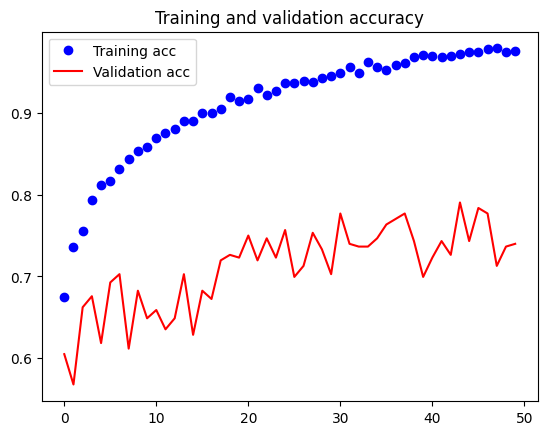

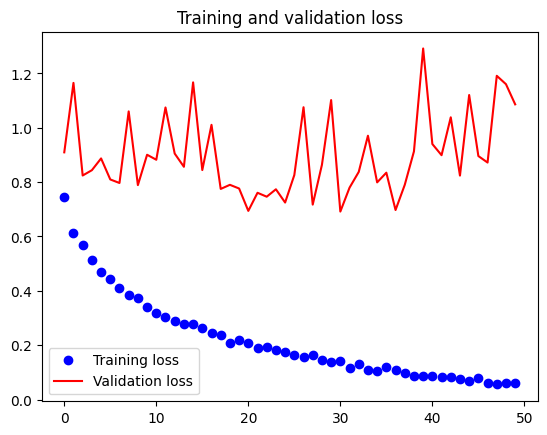

In [ ]:
import matplotlib.pyplot as plt

acc = fit_generator_3.history['acc']
val_acc = fit_generator_3.history['val_acc']
loss = fit_generator_3.history['loss']
val_loss = fit_generator_3.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc', color = 'r')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color = 'r')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
## Added more types of Data Augmentation for experimenting
## Goal is to get more data

train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        fill_mode='nearest',
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(224, 224),
        batch_size=50,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_path,
        target_size=(224, 224),
        batch_size=10,
        class_mode='categorical')

## set steps per epoch for train
train_filenames = train_generator.filenames
steps_train = len(train_filenames)/train_generator.batch_size

## set steps per epoch for validation
validation_filenames = validation_generator.filenames
steps_valid = len(validation_filenames)/validation_generator.batch_size

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

fit_generator_4 = model.fit_generator(
        train_generator,
        steps_per_epoch=steps_train,
        epochs=30,
        validation_data=validation_generator,
        validation_steps=steps_valid)

Found 2640 images belonging to 3 classes.
Found 296 images belonging to 3 classes.


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
<ipython-input-16-05e52a70d2ce>:40: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  fit_generator_4 = model.fit_generator(


Epoch 1/30
52/52 [==============================] - 44s 816ms/step - loss: 0.3789 - acc: 0.8754 - val_loss: 0.7831 - val_acc: 0.7466
Epoch 2/30
52/52 [==============================] - 41s 769ms/step - loss: 0.2696 - acc: 0.9019 - val_loss: 0.7716 - val_acc: 0.7432
Epoch 3/30
52/52 [==============================] - 41s 777ms/step - loss: 0.2718 - acc: 0.8894 - val_loss: 0.6928 - val_acc: 0.7770
Epoch 4/30
52/52 [==============================] - 42s 793ms/step - loss: 0.2423 - acc: 0.9068 - val_loss: 0.5621 - val_acc: 0.7973
Epoch 5/30
52/52 [==============================] - 41s 768ms/step - loss: 0.2379 - acc: 0.9038 - val_loss: 0.6032 - val_acc: 0.7635
Epoch 6/30
52/52 [==============================] - 41s 773ms/step - loss: 0.2463 - acc: 0.9008 - val_loss: 0.5530 - val_acc: 0.8041
Epoch 7/30
52/52 [==============================] - 41s 777ms/step - loss: 0.2192 - acc: 0.9117 - val_loss: 0.5742 - val_acc: 0.8041
Epoch 8/30
52/52 [==============================] - 41s 767ms/step - 

In [ ]:
import matplotlib.pyplot as plt

acc = fit_generator_4.history['acc']
val_acc = fit_generator_4.history['val_acc']
loss = fit_generator_4.history['loss']
val_loss = fit_generator_4.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc', color = 'r')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color = 'r')
plt.title('Training and validation loss')
plt.legend()

plt.show()

SyntaxError: ignored

In [ ]:
model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224, 224, 3)))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Flatten())
model2.add(layers.Dense(512, activation='relu'))
model2.add(Dropout(0.5))
model2.add(layers.Dense(3, activation='softmax'))
model2.summary()
model.save('groceries_basic_model_dropout')

NameError: ignored

In [ ]:
## Added more types of Data Augmentation for experimenting
## Goal is to get more data

train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        fill_mode='nearest',
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(224, 224),
        batch_size=20,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_path,
        target_size=(224, 224),
        batch_size=10,
        class_mode='categorical')

model2.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

model2_fit_generator = model2.fit_generator(
        train_generator,
        steps_per_epoch=75,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=30)

NameError: ignored

In [ ]:
model2.save('groceries_basic_model_dropout')

NameError: ignored

In [ ]:
import matplotlib.pyplot as plt

acc = model2_fit_generator.history['acc']
val_acc = model2_fit_generator.history['val_acc']
loss = model2_fit_generator.history['loss']
val_loss = model2_fit_generator.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc', color = 'r')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color = 'r')
plt.title('Training and validation loss')
plt.legend()

plt.show()

NameError: ignored

In [ ]:
model2_test_datagen = ImageDataGenerator(rescale=1./255)

model2_test_generator = model2_test_datagen.flow_from_directory(
        test_path,
        target_size=(224, 224),
        batch_size=1,
        shuffle = False,
        class_mode='categorical')

filenames = model2_test_generator.filenames
nb_samples = len(filenames)

model2_predict = model2.predict_generator(model2_test_generator,steps = nb_samples, verbose=2)

NameError: ignored

In [ ]:
y_true = model2_test_generator.classes
y_pred = model2_predict.argmax(axis=1)
plot_confusion_matrix(y_true, y_pred, classes=['fruits','packages','vegetables'],
                      title='Confusion matrix, without normalization')
#plots(test_images, titles=test_labels)
print(filenames)

NameError: ignored

In [ ]:
#@title Run this to import the right things
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import random
from six.moves import urllib
import io
import shutil
import keras
from IPython.display import clear_output, Image, display, HTML


import tensorflow as tf
import tensorflow_hub as hub

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as sk_metrics
import time
from keras_applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.inception_v3 import InceptionV3
from keras_applications.resnet50 import preprocess_input, decode_predictions, ResNet50
from keras.preprocessing import image
from keras import regularizers
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Flatten
from keras import backend as K

In [ ]:
from keras.applications.vgg16 import VGG16
vgg_model = VGG16(weights = 'imagenet')

In [ ]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

vgg_transfer_base_model = Sequential()

for layer in vgg_model.layers[:-1]:
  vgg_transfer_base_model.add(layer)

vgg_transfer_base_model.layers.pop()
for layer in vgg_transfer_base_model.layers:
  layer.trainable=False

vgg_transfer_base_model.add(Dense(512, activation = 'relu'))
vgg_transfer_base_model.add(Dropout(0.5))
vgg_transfer_base_model.add(Dense(3, activation='softmax'))
vgg_transfer_base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [ ]:
## data augmentation datagen
vgg_train_datagen_do = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        fill_mode='nearest',
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

## test generator, required for prediction
vgg_test_datagen_do = ImageDataGenerator(rescale=1./255)

## train generator
vgg_train_generator_do = vgg_train_datagen_do.flow_from_directory(
        train_path,
        target_size=(224, 224),
        batch_size=25,
        class_mode='categorical')

## validation generator
vgg_validation_generator_do = vgg_test_datagen_do.flow_from_directory(
        validation_path,
        target_size=(224, 224),
        batch_size=10,
        class_mode='categorical')

## compile model
vgg_transfer_base_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])


## set steps per epoch for train
train_filenames_do = vgg_train_generator_do.filenames
steps_train_do = len(train_filenames_do)/vgg_train_generator_do.batch_size

## set steps per epoch for validation
validation_filenames_do = vgg_validation_generator_do.filenames
steps_valid_do = len(validation_filenames_do)/vgg_validation_generator_do.batch_size

## fit model
vgg_base_fit_generator_do = vgg_transfer_base_model.fit_generator(
        vgg_train_generator_do,
        steps_per_epoch=steps_train_do,
        epochs=50,
        validation_data=vgg_validation_generator_do,
        validation_steps=steps_valid_do,
        verbose=1)

NameError: ignored